## PROTO V1.0
<div class='alert alert-success'>
Ce petit notebook permet d'évaluer Abstract Torch sur un petit réseau. 
Pour cela, on créé AbstractNN, un petit réseau composé de 3 couches de convolution suivies de ReLU, puis de deux couches FC suivies également de ReLU. 
Pour l'entrainement uniquement, un softmax est appliqué en sortie de réseau
</div>

Dans la classe AbstractNN, la méthode forward de nn.Linear est surchargée de façon standard.
C'est à dire que si l'on instancie model=AbstractNN(), model(x) applique forward à x comme dans n'importe quel réseau. 

AbstractNN possède une méthode abstract_forward() qui fait appelle à AbstractLinear et AbstractReLU. 
<div class='alert alert-info'>
Le lecteur avisé notera que 
    model(x)=nn.softmax(model.abstract_forward(x_abstract)[0])
</div>



In [57]:


%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn

from abstractModule import AbstractLinear as AL
from abstractModule import AbstractReLU as AR

from util.custom_train import CustomTrainer as T
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split
from torch import optim
import os




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Ici on importe le dataset CIFAR0, normalisation et random split pour l'entrainement

In [39]:

path ='dataset'

os.makedirs(path, exist_ok=True)

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean =[0.5], std =[0.2]),
        #transforms.Resize((56,56))
    ])



dataset_train = datasets.FashionMNIST(root = path,transform = transform, download = True, train = True)
dataset_test =datasets.FashionMNIST( root =path,transform=transform ,download = True, train = False)
val =0.2
len_data_train = len(dataset_train)
train_size =int((1-val)*len_data_train)

val_size = int(val*len_data_train)

train_dataset, val_dataset = random_split(dataset_train, [train_size,val_size])


Ici on génère notre classe AbstractNN et sa fameuse méthode abstrac_forward


In [58]:


class AbstractNN(nn.Module):
    
    def __init__(self,num_depth=1,device=torch.device("cpu")):

        super(AbstractNN,self).__init__()
       
      
        self.num_depth = num_depth
        self.device = device
        self.conv1=nn.Conv2d(self.num_depth,16,3,device=self.device)
        self.conv2=nn.Conv2d(16,32,3,device=self.device)
  

       

        self.fc1=nn.Sequential(nn.Flatten(),nn.Linear(18432,64,device=self.device))
        self.fc2=nn.Sequential(nn.Flatten(),nn.Linear(64,10,device=self.device))
        self.softMax =nn.Softmax()
    def forward(self,x):
        x=self.conv1(x)
        x=torch.relu(x)
        x=self.conv2(x)
        x=torch.relu(x)
    
    
        x=self.fc1(x)
        x=torch.relu(x)
        x=self.fc2(x)
        x=torch.relu(x)
        x= self.softMax(x)
        return x
    
    def abstract_forward(self,x,add_symbol=False,device=torch.device("cpu")):
        self.device=device
        
        x_true = x
        x_true = x_true[0].unsqueeze(0)

        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
     
       
        x,x_min,x_max,x_true = AL.abstract_conv2D(self.conv2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu_conv2D(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc1,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
      
        x,x_min,x_max,x_true = AL.abstract_linear(self.fc2,x,x_true,device=self.device)
        x,x_min,x_max,x_true = AR.abstract_relu(x,x_min,x_max,x_true,add_symbol=add_symbol,device =self.device)
       
        
        return x,x_min,x_max,x_true
        

Un petit script pour l'entrainement, disons 40 EPOCH

In [8]:
model =AbstractNN(num_depth=1,device=torch.device('mps'))

num_epochs =10
learning_rate=0.01
batch_size = 128
device = torch.device('mps')
optimizer = optim.Adam(model.parameters(), betas=(0.9, 0.99))
scheduler =  optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.98)
criterion = nn.CrossEntropyLoss()
TD= T(model=model,
            device=device
                            )
model = TD.train_model(train_dataset,val_dataset,
                        criterion=criterion,  
                        batch_size= batch_size,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        num_epochs=num_epochs,
                        learning_rate=learning_rate,
                        resname='SimpleCNN',verbose=False)

----------------------------------------------------------------------------------------------------
Epoch 0/10
----------------------------------------------------------------------------------------------------
EPOCH ACCURACY = 52.54 %
****************************************************************************************************
train Loss: 1.7152 Acc: 52.5391
****************************************************************************************************
EPOCH ACCURACY = 75.82 %
****************************************************************************************************
val Loss: 1.8108 Acc: 75.8232
****************************************************************************************************

----------------------------------------------------------------------------------------------------
Epoch 1/10
----------------------------------------------------------------------------------------------------
EPOCH ACCURACY = 75.20 %
********************************

In [59]:
model=AbstractNN(num_depth=1,device=torch.device('mps')    )
model.load_state_dict(torch.load('dataset/SimpleCNN_9_valacc_88.92809295654297.pth'))

<All keys matched successfully>

Label:1


torch.Size([1, 28, 28])

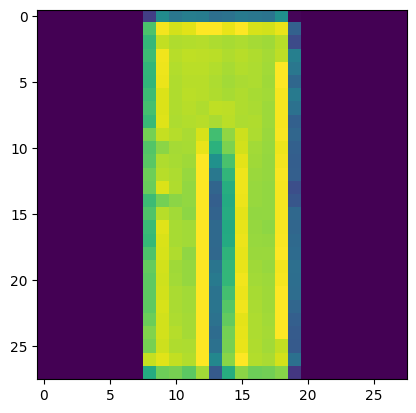

In [60]:
import matplotlib.pyplot as plt
import numpy as np

img, label = dataset_train[151]
plt.imshow(img[0])
print(f"Label:{label}")
img.shape

In [61]:
max= torch.max(img)
min = torch.min(img)
scale = max-min
print(scale)

from abstract import abstractTensor as AT

x=AT(img,alpha =0.1*scale*torch.ones(28*28))
x=x.abstract_tensor()
x.shape
x=x.to(device)


tensor(5.)
torch.Size([1, 28, 28])


In [63]:
with torch.no_grad():
   result_1= model(x[0].unsqueeze(0))  
 
   result,x_min,x_max,x_true=model.abstract_forward(x,add_symbol=False,device=torch.device('mps'))

print(f"y_min       =  {x_min}")
print(f"y_max       =  {x_max}")
print(f"center Ztp  =  {result[0]}")
print(f"y_true      =  {x_true[:]}")
print(f"y_max-x_min =  {x_max-x_min}")
print(f"Trash symbol=  {result[-1]}")


x.shape=torch.Size([786, 1, 28, 28])
x.shape=torch.Size([786, 16, 26, 26])
torch.mps.FloatTensor
torch.mps.FloatTensor
y_min       =  tensor([-1061.0667, -2411.8379, -1893.1394, -1318.5994, -1987.1194, -1955.1594,
        -2075.0361, -2076.4966, -2201.0068, -2032.3173], device='mps:0')
y_max       =  tensor([1765.2549, 4433.8540, 3756.4128, 2438.4661, 3677.7039, 3644.8381,
        3823.1348, 3657.1904, 4178.8008, 3873.8770], device='mps:0')
center Ztp  =  tensor([ 352.0941, 1011.0081,  931.6367,  559.9333,  845.2923,  844.8394,
         874.0494,  790.3468,  988.8971,  920.7799], device='mps:0')
y_true      =  tensor([[ 0.0000, 20.4091,  0.0000,  5.9814,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000]], device='mps:0')
y_max-x_min =  tensor([2826.3215, 6845.6919, 5649.5522, 3757.0654, 5664.8232, 5599.9976,
        5898.1709, 5733.6870, 6379.8076, 5906.1943], device='mps:0')
Trash symbol=  tensor([1406.2231, 3400.4595, 2798.9148, 1864.9375, 2804.0410, 2778.2612,
        2

/Users/guillaumeberthelot/anaconda3/envs/NumalisEnv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Voici le premier affichage de relevance calculé par AbstractTorch

tensor(2, device='mps:0')
torch.Size([784])


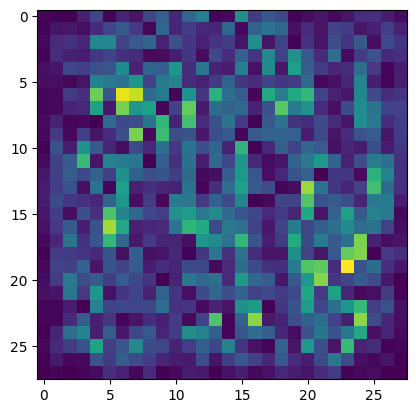

In [37]:
value=torch.argmax(result[0])
print(value)
concat= torch.abs(result[1:785,value])
print(concat.size())

concat = concat.reshape(28,28)
plt.imshow(torch.abs(concat.cpu()).numpy(), cmap='viridis')

In [51]:
print(result[3:5])

tensor([[ 0.0011,  0.0013, -0.0039,  0.0012, -0.0045,  0.0067, -0.0115, -0.0015,
         -0.0049,  0.0115],
        [-0.0002, -0.0028,  0.0111, -0.0015,  0.0071,  0.0115, -0.0055, -0.0057,
          0.0044,  0.0183]], device='mps:0')


In [56]:
conv= nn.Conv2d(1,16,3)
conv.weight.data=torch.abs(conv.weight.data)
conv.weight

Parameter containing:
tensor([[[[0.2537, 0.0167, 0.1305],
          [0.1052, 0.1695, 0.2609],
          [0.0886, 0.0025, 0.2177]]],


        [[[0.2761, 0.0884, 0.1541],
          [0.2721, 0.0814, 0.1246],
          [0.1325, 0.3320, 0.2972]]],


        [[[0.1891, 0.1927, 0.2050],
          [0.2753, 0.0490, 0.2952],
          [0.1593, 0.0976, 0.2917]]],


        [[[0.0159, 0.2230, 0.1096],
          [0.1043, 0.2483, 0.1768],
          [0.2012, 0.0115, 0.1176]]],


        [[[0.2600, 0.2561, 0.0105],
          [0.1662, 0.1928, 0.1613],
          [0.2476, 0.2930, 0.0605]]],


        [[[0.1119, 0.1599, 0.3238],
          [0.0440, 0.0880, 0.2949],
          [0.0684, 0.0060, 0.1955]]],


        [[[0.0143, 0.1668, 0.1858],
          [0.2134, 0.1904, 0.2757],
          [0.0364, 0.0386, 0.0589]]],


        [[[0.2726, 0.3283, 0.2754],
          [0.1503, 0.0856, 0.0088],
          [0.1148, 0.2760, 0.0522]]],


        [[[0.2409, 0.2117, 0.2828],
          [0.0393, 0.2832, 0.1491],
          